In [1]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [211]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import time  
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, confusion_matrix, accuracy_score, f1_score, r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LogisticRegression, LinearRegression
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
import xgboost as xgb
from torch.utils.tensorboard import SummaryWriter
import neptune
import optuna
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from datetime import datetime
import shap
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Загружаем наш датасет и проверяем его

In [3]:
df = pd.read_csv('content/ParisHousing.csv')

In [4]:
df

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1726,89,0,1,5,73133,7,6,2009,0,1,9311,1698,218,0,4,176425.9
9996,44403,29,1,1,12,34606,9,4,1990,0,1,9061,1742,230,0,0,4448474.0
9997,83841,3,0,0,69,80933,10,10,2005,1,1,8304,7730,345,1,9,8390030.5
9998,59036,70,0,0,96,55856,1,3,2010,0,1,2590,6174,339,1,4,5905107.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

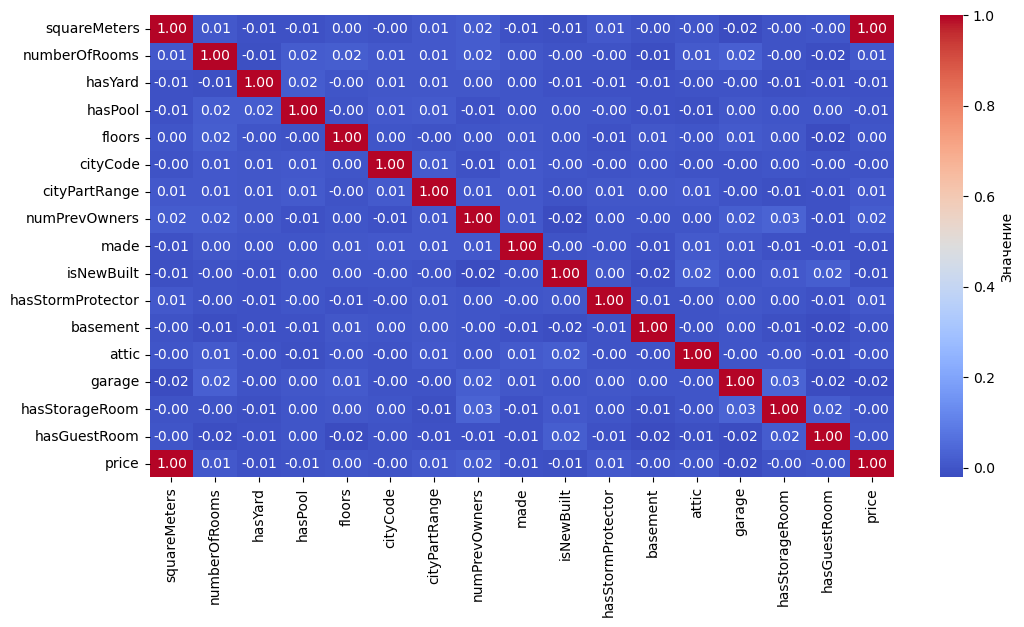

In [6]:
plt.figure(figsize=(12, 6)) 
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Значение'})
plt.show()

In [7]:
df.corr()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
squareMeters,1.000000,0.009573,-0.006650,-0.005594,0.001109,-0.001541,0.008758,0.016619,-0.007207,-0.010667,0.007480,-0.003960,-0.000588,-0.017246,-0.003486,-0.000623,0.999999
numberOfRooms,0.009573,1.000000,-0.011240,0.017015,0.022244,0.009040,0.008340,0.016766,0.003978,-0.002865,-0.001656,-0.013990,0.012061,0.023188,-0.004760,-0.015529,0.009591
hasYard,-0.006650,-0.011240,1.000000,0.015514,-0.000883,0.006760,0.005023,0.004279,0.002214,-0.008370,-0.007598,-0.008558,-0.003085,-0.004626,-0.009506,-0.007276,-0.006119
hasPool,-0.005594,0.017015,0.015514,1.000000,-0.004006,0.008072,0.014613,-0.006848,0.001894,0.000188,-0.001001,-0.007268,-0.011901,0.004832,0.001238,0.001123,-0.005070
floors,0.001109,0.022244,-0.000883,-0.004006,1.000000,0.002207,-0.004921,0.002463,0.005022,0.002458,-0.008566,0.006228,-0.000270,0.011303,0.003616,-0.021155,0.001654
cityCode,-0.001541,0.009040,0.006760,0.008072,0.002207,1.000000,0.011334,-0.007549,0.009266,-0.000224,-0.004941,0.002652,-0.002019,-0.002208,0.002554,-0.003338,-0.001539
cityPartRange,0.008758,0.008340,0.005023,0.014613,-0.004921,0.011334,1.000000,0.009238,0.007748,-0.001874,0.005224,0.004743,0.010696,-0.001648,-0.011338,-0.007153,0.008813
numPrevOwners,0.016619,0.016766,0.004279,-0.006848,0.002463,-0.007549,0.009238,1.000000,0.006858,-0.017420,0.002522,-0.000862,0.000719,0.020268,0.031707,-0.006082,0.016619
made,-0.007207,0.003978,0.002214,0.001894,0.005022,0.009266,0.007748,0.006858,1.000000,-0.001678,-0.000645,-0.005506,0.013773,0.005687,-0.007868,-0.005431,-0.007210
isNewBuilt,-0.010667,-0.002865,-0.008370,0.000188,0.002458,-0.000224,-0.001874,-0.017420,-0.001678,1.000000,0.003200,-0.015986,0.020127,0.002749,0.007011,0.019895,-0.010643


### Интересные данные: исключительно низкая корреляция всех параметров кроме метража. Попробую потестировать дополнительно например MI

## Попробуем получить важность параметров

In [8]:
# Целевая переменная
y = df['price']
X = df.drop(columns=['price'])

In [9]:
# Вычисляем MI
mi_scores = mutual_info_regression(X, y)

# Оформляем результат в DataFrame
mi_scores = pd.Series(mi_scores, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Выводим топ-10 признаков
print(mi_scores)

squareMeters         6.566358
cityCode             0.026265
numPrevOwners        0.012794
cityPartRange        0.011770
floors               0.009026
numberOfRooms        0.009001
hasYard              0.007757
attic                0.005434
isNewBuilt           0.004307
hasGuestRoom         0.002099
hasStorageRoom       0.000711
hasPool              0.000356
made                 0.000000
hasStormProtector    0.000000
basement             0.000000
garage               0.000000
dtype: float64


### Снова важность есть только у метража. Попробуем его исключить

In [10]:
X_prob = df.drop(columns=['price','squareMeters'])

In [11]:
# Вычисляем MI
mi_scores = mutual_info_regression(X_prob, y)

# Оформляем результат в DataFrame
mi_scores = pd.Series(mi_scores, index=X_prob.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Выводим топ-10 признаков
print(mi_scores)

cityCode             0.026293
numPrevOwners        0.012794
cityPartRange        0.011770
hasYard              0.007757
attic                0.005367
isNewBuilt           0.004307
numberOfRooms        0.003532
floors               0.002892
hasGuestRoom         0.002099
hasStorageRoom       0.000711
hasPool              0.000356
made                 0.000000
hasStormProtector    0.000000
basement             0.000000
garage               0.000000
dtype: float64


### Важность несколько выравнялась. Но даже до 0.1 не подтянулась. Протестируем удаление еще некоторых параметров

In [12]:
X_prob2 = df.drop(columns=['price','hasGuestRoom','squareMeters'])

In [13]:
# Вычисляем MI
mi_scores = mutual_info_regression(X_prob2, y)

# Оформляем результат в DataFrame
mi_scores = pd.Series(mi_scores, index=X_prob2.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Выводим топ-10 признаков
print(mi_scores)

cityCode             0.026267
numPrevOwners        0.012794
cityPartRange        0.011765
hasYard              0.007757
numberOfRooms        0.007011
floors               0.006065
attic                0.005413
isNewBuilt           0.004287
hasStorageRoom       0.000691
hasPool              0.000356
made                 0.000000
hasStormProtector    0.000000
basement             0.000000
garage               0.000000
dtype: float64


### Вывод: дальнейшие удаления фичей эффекта не приносят. Поэтому удалим фичи с нулевыем MI, а остльаные объединим в одну фичу.

In [138]:
# Исключаем ненужные признаки (малая корреляция 0-е MI)
drop_columns = ['price', 'made', 'hasStormProtector', 'basement', 'garage']
X_prob3 = df.drop(columns=drop_columns)

# Применяем PCA для одного компонента
pca = PCA(n_components=1)
quality_index = pca.fit_transform(X_prob3)

# Создаём финальный DataFrame с новым признаком
X_final = pd.DataFrame(quality_index, columns=['quality_index'])

# Добавляем столбцы 'hasGuestRoom' и 'squareMeters' из основного датасета
X_final['hasGuestRoom'] = df['hasGuestRoom']
X_final['squareMeters'] = df['squareMeters']

# Проверяем форму данных
print(X_final.shape)

(10000, 3)


In [139]:
X_final

,quality_index,hasGuestRoom,squareMeters
0,-43094.783446,7,75523
1,-13715.766883,2,80771
2,-16250.757340,9,55712
3,-20528.176357,3,32316
4,-14068.401226,4,70429
...,...,...,...
9995,27355.568553,4,1726
9996,-15032.251094,0,44403
9997,27359.078271,9,83841
9998,4738.854559,4,59036


## Вначале проведем тесты для общих данных со всеми фичами

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [181]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [182]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [183]:
# Конвертируем в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

In [33]:
load_dotenv()

True

In [115]:
run = neptune.init_run(
        project=os.getenv("NEPTUNE_PROJECT"), 
        api_token=os.getenv("NEPTUNE_API_TOKEN"),
        capture_stdout=True,
        capture_stderr=True,
        capture_traceback=True,
        capture_hardware_metrics=True
    ) 

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/saatarko/financescoring/e/FIN-29


In [94]:
class ParisDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            # Возвращаем как тензоры
            return self.X[idx].float(), self.y[idx].float()
        return self.X[idx].float()

# Создаём датасеты
train_dataset = ParisDataset(X_train_tensor, y_train_tensor)
val_dataset = ParisDataset(X_val_tensor, y_val_tensor)  
test_dataset = ParisDataset(X_test_tensor, y_test_tensor)

## Подбирать параметры будем через neptuna+optuna +pytorch

In [120]:
def train_model(config, trial):

    results = []  # Инициализация списка для хранения результатов
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
  
    epochs = 600 

    # Подготовка данных
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
    
    # Инициализация модели и оптимизатора
    model = SimpleNN(config["num_layers"], config["layers"], config["dropout"], config["activation"]).to(device)
    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=config["learning_rate"]),
        "SGD": optim.SGD(model.parameters(), lr=config["learning_rate"]),
        "RMSprop": optim.RMSprop(model.parameters(), lr=config["learning_rate"]),
    }[config["optimizer"]]
    
    # Используем Huber Loss (SmoothL1Loss)
    criterion = nn.SmoothL1Loss()  # Huber Loss
    
    # Логирование гиперпараметров в Neptune
    run[f'trials/{trial.number}/parameters'] = {
        'learning_rate': config["learning_rate"],
        'batch_size': config["batch_size"],
        'num_layers': config["num_layers"],
        'layers': config["layers"],
        'dropout': config["dropout"],
        'activation': config["activation"],
        'optimizer': config["optimizer"]
    }
    
    # Инициализация TensorBoard
    writer = SummaryWriter(log_dir=f'content/logs/{trial.number}')
    
    # Параметры ранней остановки
    patience = 30  # количество эпох без улучшений до остановки
    best_val_loss = np.inf
    epochs_no_improve = 0
    best_model_wts = None

    # Списки для логирования потерь
    train_losses = []
    val_losses = []
    val_mses = []  # Для MSE на валидации
    val_maes = []  # Для MAE на валидации

    start_time = time.time()

    for epoch in range(epochs):  # теперь epochs определена
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Ограничиваем значение градиентов
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    
            optimizer.step()
    
            running_loss += loss.item()

        # Логирование потерь на TensorBoard
        writer.add_scalar('Loss/train', running_loss / len(train_loader), epoch)
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        val_mse = 0.0  # Для удобства хранения MSE
        val_mae = 0.0  # Для удобства хранения MAE
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
                # Для регрессии считаем MSE и MAE
                val_mse += mean_squared_error(labels.cpu(), outputs.cpu())
                val_mae += torch.mean(torch.abs(labels.cpu() - outputs.cpu()))
        
        # Среднее значение MSE и MAE для всех батчей
        val_mse /= len(val_loader)
        val_mae /= len(val_loader)
        val_losses.append(val_loss / len(val_loader))
        
        # Логируем MSE и MAE на валидации в Neptune
        run[f'trials/{trial.number}/epoch/{epoch+1}/val_mse'] = val_mse
        run[f'trials/{trial.number}/epoch/{epoch+1}/val_mae'] = val_mae
        
        # print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}, Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_wts = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

    # Восстановим лучшие веса
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    else:
        print("Нет лучших весов для загрузки.")
    
    writer.flush()
    writer.close()

    # Сохраняем результаты
    results.append({
        "loss": best_val_loss,
        "optimizer": config["optimizer"],
        "device": device,
        "val_mse": val_mse,
        "val_mae": val_mae,
        "training_time": time.time() - start_time,
        "train_losses": train_losses,
        "val_losses": val_losses
    })
    
    # Логируем метрики в Neptune по эпохам
    for epoch in range(len(train_losses)):
        run[f"trials/{trial.number}/metrics/train_loss"].log(train_losses[epoch], step=epoch)
        run[f"trials/{trial.number}/metrics/val_loss"].log(val_losses[epoch], step=epoch)
        run[f"trials/{trial.number}/metrics/val_mse"].log(val_mses[epoch], step=epoch)
        run[f"trials/{trial.number}/metrics/val_mae"].log(val_maes[epoch], step=epoch)


    # Выводим все результаты
    print("\n📊 Итоговые результаты:")
    for res in results:
        print(f"Loss: {res['loss']} + {res['optimizer']} на {res['device']} | MSE: {res['val_mse']:.4f} | MAE: {res['val_mae']:.4f} | Время обучения: {res['training_time']}")

    # Возвращаем метрику для оптимизации в Optuna
    return best_val_loss

In [113]:
# Определение конфигурации гиперпараметров для Optuna
def objective(trial):
    config = {
        "learning_rate": trial.suggest_categorical("learning_rate", [0.1, 0.01, 0.001]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64]),
        "num_layers": trial.suggest_int("num_layers", 2, 6),
        "layers": trial.suggest_categorical("layers", [35, 50, 75, 100, 250, 350, 500]),
        "dropout": trial.suggest_float("dropout", 0.1, 0.3),
        "activation": trial.suggest_categorical("activation", ["relu", "leaky_relu"]),
        "optimizer": trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"]),
    }

    # Передаем конфигурацию в функцию обучения
    return train_model(config, trial)

In [116]:
# Запуск оптимизации с Optuna
study = optuna.create_study(direction="minimize")  # Минимизируем потери
study.optimize(objective, n_trials=40)

# Логируем лучшие параметры
best_params = study.best_params
best_mse = study.best_value

run.stop()

print(f"Best parameters: {best_params}")
print(f"Best mse: {best_mse}")

[I 2025-03-25 16:28:30,512] A new study created in memory with name: no-name-81f7d7ef-4b8b-4fe1-a349-d739012c1774
[I 2025-03-25 16:29:49,711] Trial 0 finished with value: 862612.607421875 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 4, 'layers': 50, 'dropout': 0.17283682269675155, 'activation': 'leaky_relu', 'optimizer': 'SGD'}. Best is trial 0 with value: 862612.607421875.


⏹️ Early stopping at epoch 254

📊 Итоговые результаты:
Loss: 862612.607421875 + SGD на cuda | MSE: 5265767464.9600 | MAE: 64261.1641 | Время обучения: 79.16737580299377


[I 2025-03-25 16:30:20,305] Trial 1 finished with value: 6399139.1875 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 4, 'layers': 75, 'dropout': 0.16278628497212644, 'activation': 'leaky_relu', 'optimizer': 'RMSprop'}. Best is trial 0 with value: 862612.607421875.


⏹️ Early stopping at epoch 92

📊 Итоговые результаты:
Loss: 6399139.1875 + RMSprop на cuda | MSE: 338600807628.8000 | MAE: 445693.1875 | Время обучения: 30.57328486442566


[I 2025-03-25 16:31:36,361] Trial 2 finished with value: 1357004.91015625 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'num_layers': 3, 'layers': 500, 'dropout': 0.11227971898360732, 'activation': 'relu', 'optimizer': 'SGD'}. Best is trial 0 with value: 862612.607421875.


⏹️ Early stopping at epoch 138

📊 Итоговые результаты:
Loss: 1357004.91015625 + SGD на cuda | MSE: 1601983157.7600 | MAE: 31605.2656 | Время обучения: 76.03120350837708


[I 2025-03-25 16:31:48,976] Trial 3 finished with value: 41185871.0 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 5, 'layers': 50, 'dropout': 0.23475814549914267, 'activation': 'leaky_relu', 'optimizer': 'SGD'}. Best is trial 0 with value: 862612.607421875.


⏹️ Early stopping at epoch 32

📊 Итоговые результаты:
Loss: 41185871.0 + SGD на cuda | MSE: 10160990846976.0000 | MAE: 2788103.7500 | Время обучения: 12.590619325637817


[I 2025-03-25 16:32:21,002] Trial 4 finished with value: 984013.00390625 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 3, 'layers': 75, 'dropout': 0.29775005444745184, 'activation': 'relu', 'optimizer': 'SGD'}. Best is trial 0 with value: 862612.607421875.


⏹️ Early stopping at epoch 110

📊 Итоговые результаты:
Loss: 984013.00390625 + SGD на cuda | MSE: 5635179130.8800 | MAE: 60465.5469 | Время обучения: 32.00939083099365


[I 2025-03-25 16:32:51,979] Trial 5 finished with value: 26641488.96875 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'num_layers': 5, 'layers': 250, 'dropout': 0.19190772763665118, 'activation': 'leaky_relu', 'optimizer': 'SGD'}. Best is trial 0 with value: 862612.607421875.


⏹️ Early stopping at epoch 44

📊 Итоговые результаты:
Loss: 26641488.96875 + SGD на cuda | MSE: 5768233475274713088.0000 | MAE: 76637888.0000 | Время обучения: 30.952025175094604


[I 2025-03-25 16:33:44,126] Trial 6 finished with value: 3526322.1328125 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'num_layers': 4, 'layers': 100, 'dropout': 0.14122060938621483, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 0 with value: 862612.607421875.


⏹️ Early stopping at epoch 78

📊 Итоговые результаты:
Loss: 3526322.1328125 + RMSprop на cuda | MSE: 150872331223.0400 | MAE: 340457.6875 | Время обучения: 52.116517543792725


[I 2025-03-25 16:34:17,756] Trial 7 finished with value: 3840847.03515625 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'num_layers': 4, 'layers': 100, 'dropout': 0.11042205088914046, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 0 with value: 862612.607421875.


⏹️ Early stopping at epoch 50

📊 Итоговые результаты:
Loss: 3840847.03515625 + Adam на cuda | MSE: 31109247406.0800 | MAE: 152411.2812 | Время обучения: 33.60402822494507


[I 2025-03-25 16:35:23,509] Trial 8 finished with value: 984402.71484375 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 5, 'layers': 350, 'dropout': 0.24560268013429462, 'activation': 'leaky_relu', 'optimizer': 'Adam'}. Best is trial 0 with value: 862612.607421875.


⏹️ Early stopping at epoch 168

📊 Итоговые результаты:
Loss: 984402.71484375 + Adam на cuda | MSE: 8857009070.0800 | MAE: 77323.3828 | Время обучения: 65.72274661064148


[I 2025-03-25 16:36:09,737] Trial 9 finished with value: 505589.54296875 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 2, 'layers': 250, 'dropout': 0.12098281754351181, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 9 with value: 505589.54296875.


⏹️ Early stopping at epoch 130

📊 Итоговые результаты:
Loss: 505589.54296875 + RMSprop на cuda | MSE: 1372631552.0000 | MAE: 29620.0332 | Время обучения: 46.20758843421936


[I 2025-03-25 16:36:54,380] Trial 10 finished with value: 540683.63671875 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 2, 'layers': 250, 'dropout': 0.2279671097085171, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 9 with value: 505589.54296875.


⏹️ Early stopping at epoch 147

📊 Итоговые результаты:
Loss: 540683.63671875 + RMSprop на cuda | MSE: 1833092423.6800 | MAE: 35419.6289 | Время обучения: 44.607749462127686


[I 2025-03-25 16:37:20,585] Trial 11 finished with value: 636166.3046875 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 2, 'layers': 250, 'dropout': 0.22613309633617867, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 9 with value: 505589.54296875.


⏹️ Early stopping at epoch 100

📊 Итоговые результаты:
Loss: 636166.3046875 + RMSprop на cuda | MSE: 1704139642.8800 | MAE: 33029.2969 | Время обучения: 26.174389600753784


[I 2025-03-25 16:38:01,319] Trial 12 finished with value: 1916542.1484375 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 2, 'layers': 35, 'dropout': 0.2653851944619029, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 9 with value: 505589.54296875.


⏹️ Early stopping at epoch 148

📊 Итоговые результаты:
Loss: 1916542.1484375 + RMSprop на cuda | MSE: 16750113710.0800 | MAE: 117249.4375 | Время обучения: 40.69993233680725


[I 2025-03-25 16:38:30,500] Trial 13 finished with value: 667088.20703125 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 2, 'layers': 250, 'dropout': 0.20436008094825103, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 9 with value: 505589.54296875.


⏹️ Early stopping at epoch 101

📊 Итоговые результаты:
Loss: 667088.20703125 + RMSprop на cuda | MSE: 2475509923.8400 | MAE: 39895.9258 | Время обучения: 29.156571626663208


[I 2025-03-25 16:38:51,316] Trial 14 finished with value: 1471735.8125 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.13998456748748153, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 9 with value: 505589.54296875.


⏹️ Early stopping at epoch 69

📊 Итоговые результаты:
Loss: 1471735.8125 + RMSprop на cuda | MSE: 15570860318.7200 | MAE: 100163.8828 | Время обучения: 20.789785861968994


[I 2025-03-25 16:40:40,482] Trial 15 finished with value: 4576084.671875 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 6, 'layers': 250, 'dropout': 0.2019382951266926, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 9 with value: 505589.54296875.


⏹️ Early stopping at epoch 228

📊 Итоговые результаты:
Loss: 4576084.671875 + RMSprop на cuda | MSE: 95933891051.5200 | MAE: 245828.1406 | Время обучения: 109.13792014122009


[I 2025-03-25 16:41:29,964] Trial 16 finished with value: 1612573.59375 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 2, 'layers': 35, 'dropout': 0.27289566091988987, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 9 with value: 505589.54296875.


⏹️ Early stopping at epoch 178

📊 Итоговые результаты:
Loss: 1612573.59375 + Adam на cuda | MSE: 20538523525.1200 | MAE: 124327.5391 | Время обучения: 49.45841932296753


[I 2025-03-25 16:42:04,364] Trial 17 finished with value: 3117872.8046875 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 3, 'layers': 500, 'dropout': 0.14678525088268463, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 9 with value: 505589.54296875.


⏹️ Early stopping at epoch 104

📊 Итоговые результаты:
Loss: 3117872.8046875 + RMSprop на cuda | MSE: 65289534341.1200 | MAE: 211065.5938 | Время обучения: 34.35819983482361


[I 2025-03-25 16:42:45,061] Trial 18 finished with value: 5865319.3046875 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'num_layers': 2, 'layers': 350, 'dropout': 0.22458789865971407, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 9 with value: 505589.54296875.


⏹️ Early stopping at epoch 83

📊 Итоговые результаты:
Loss: 5865319.3046875 + RMSprop на cuda | MSE: 85769305948.1600 | MAE: 241863.9219 | Время обучения: 40.653541564941406


[I 2025-03-25 16:44:06,519] Trial 19 finished with value: 509351.05078125 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.10105235258145016, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 9 with value: 505589.54296875.


⏹️ Early stopping at epoch 248

📊 Итоговые результаты:
Loss: 509351.05078125 + RMSprop на cuda | MSE: 1177902986.2400 | MAE: 27959.0430 | Время обучения: 81.42795014381409


[I 2025-03-25 16:45:44,049] Trial 20 finished with value: 458824.8984375 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.10439348664601776, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 311

📊 Итоговые результаты:
Loss: 458824.8984375 + Adam на cuda | MSE: 2300495257.6000 | MAE: 41418.4297 | Время обучения: 97.4844434261322


[I 2025-03-25 16:46:45,650] Trial 21 finished with value: 520949.671875 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.10264411280136862, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 195

📊 Итоговые результаты:
Loss: 520949.671875 + Adam на cuda | MSE: 1743434900.4800 | MAE: 37664.8320 | Время обучения: 61.56773805618286


[I 2025-03-25 16:47:56,184] Trial 22 finished with value: 506454.220703125 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.12335627155365719, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 207

📊 Итоговые результаты:
Loss: 506454.220703125 + Adam на cuda | MSE: 1912631818.2400 | MAE: 37792.8164 | Время обучения: 70.49672055244446


[I 2025-03-25 16:48:59,432] Trial 23 finished with value: 605227.7734375 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.12481270811455965, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 171

📊 Итоговые результаты:
Loss: 605227.7734375 + Adam на cuda | MSE: 2178019051.5200 | MAE: 35584.9219 | Время обучения: 63.21474647521973


[I 2025-03-25 16:50:17,496] Trial 24 finished with value: 562475.9296875 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.12695735423382762, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 210

📊 Итоговые результаты:
Loss: 562475.9296875 + Adam на cuda | MSE: 941682542.0800 | MAE: 23824.8730 | Время обучения: 78.02769422531128


[I 2025-03-25 16:54:42,287] Trial 25 finished with value: 558966.15625 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 2, 'layers': 250, 'dropout': 0.12565046699013124, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.



📊 Итоговые результаты:
Loss: 558966.15625 + Adam на cuda | MSE: 852498854.4000 | MAE: 23671.7344 | Время обучения: 264.75958228111267
[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune asynchronous thread. All data is safe on disk and can be later synced manually using `neptune sync` command.


Exception in thread NeptuneAsyncOpProcessor:
Traceback (most recent call last):
  File "/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 111, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
                                     ^^^^^^^^^^^^^^^^^
  File "/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/home/saatarko/.cond

⏹️ Early stopping at epoch 207

📊 Итоговые результаты:
Loss: 2045344.85546875 + Adam на cuda | MSE: 3774764856.3200 | MAE: 57338.0781 | Время обучения: 144.9148886203766


[I 2025-03-25 17:00:14,991] Trial 27 finished with value: 6052068.578125 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 2, 'layers': 35, 'dropout': 0.153359828101103, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.



📊 Итоговые результаты:
Loss: 6052068.578125 + Adam на cuda | MSE: 86843423784.9600 | MAE: 242083.2812 | Время обучения: 187.7211630344391


[I 2025-03-25 17:01:31,797] Trial 28 finished with value: 753197.22265625 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 4, 'layers': 350, 'dropout': 0.12467646705450536, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 184

📊 Итоговые результаты:
Loss: 753197.22265625 + Adam на cuda | MSE: 3404113745.9200 | MAE: 46405.6797 | Время обучения: 76.76473498344421


[I 2025-03-25 17:02:34,852] Trial 29 finished with value: 547547.90234375 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 500, 'dropout': 0.18685692535249196, 'activation': 'leaky_relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 161

📊 Итоговые результаты:
Loss: 547547.90234375 + Adam на cuda | MSE: 1533227627.5200 | MAE: 31199.2773 | Время обучения: 63.00701856613159


[I 2025-03-25 17:04:47,877] Trial 30 finished with value: 710169.765625 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 4, 'layers': 100, 'dropout': 0.16183383571063736, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 315

📊 Итоговые результаты:
Loss: 710169.765625 + Adam на cuda | MSE: 3096180490.2400 | MAE: 45728.7617 | Время обучения: 132.98734307289124


[I 2025-03-25 17:05:58,371] Trial 31 finished with value: 641922.65625 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.1019378408740372, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 188

📊 Итоговые результаты:
Loss: 641922.65625 + RMSprop на cuda | MSE: 2052243845.1200 | MAE: 37770.5898 | Время обучения: 70.46175718307495


[I 2025-03-25 17:08:09,746] Trial 32 finished with value: 665585.91015625 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 4, 'layers': 75, 'dropout': 0.11500888075481162, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 268

📊 Итоговые результаты:
Loss: 665585.91015625 + RMSprop на cuda | MSE: 2323993794.5600 | MAE: 40051.4023 | Время обучения: 131.33717823028564


[I 2025-03-25 17:09:09,378] Trial 33 finished with value: 710522.3359375 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.13416403739559693, 'activation': 'relu', 'optimizer': 'SGD'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 168

📊 Итоговые результаты:
Loss: 710522.3359375 + SGD на cuda | MSE: 2869399255.0400 | MAE: 44773.9297 | Время обучения: 59.59305739402771


[I 2025-03-25 17:09:40,284] Trial 34 finished with value: 960347.4453125 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 2, 'layers': 50, 'dropout': 0.11256064949294772, 'activation': 'leaky_relu', 'optimizer': 'RMSprop'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 92

📊 Итоговые результаты:
Loss: 960347.4453125 + RMSprop на cuda | MSE: 13286827581.4400 | MAE: 101515.5625 | Время обучения: 30.873108625411987


[I 2025-03-25 17:11:09,674] Trial 35 finished with value: 553317.244140625 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.11554708849493926, 'activation': 'relu', 'optimizer': 'SGD'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 259

📊 Итоговые результаты:
Loss: 553317.244140625 + SGD на cuda | MSE: 834216565.7600 | MAE: 22923.3477 | Время обучения: 89.35342502593994


[I 2025-03-25 17:11:40,029] Trial 36 finished with value: 9584266.2734375 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'num_layers': 4, 'layers': 75, 'dropout': 0.10050880721187481, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 42

📊 Итоговые результаты:
Loss: 9584266.2734375 + Adam на cuda | MSE: 682184581447.6801 | MAE: 710779.7500 | Время обучения: 30.316549062728882


[I 2025-03-25 17:12:50,453] Trial 37 finished with value: 658315.4140625 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.15304621514402336, 'activation': 'leaky_relu', 'optimizer': 'RMSprop'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 199

📊 Итоговые результаты:
Loss: 658315.4140625 + RMSprop на cuda | MSE: 5540536862.7200 | MAE: 66319.6719 | Время обучения: 70.38879561424255


[I 2025-03-25 17:14:20,652] Trial 38 finished with value: 2503601.45703125 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'num_layers': 5, 'layers': 250, 'dropout': 0.1357492818548793, 'activation': 'relu', 'optimizer': 'SGD'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 115

📊 Итоговые результаты:
Loss: 2503601.45703125 + SGD на cuda | MSE: 79420023275.5200 | MAE: 241421.8438 | Время обучения: 90.1683440208435


[I 2025-03-25 17:14:37,274] Trial 39 finished with value: 19064196.8125 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 6, 'layers': 500, 'dropout': 0.16795108780741796, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 20 with value: 458824.8984375.


⏹️ Early stopping at epoch 31

📊 Итоговые результаты:
Loss: 19064196.8125 + Adam на cuda | MSE: 4942402913566.7197 | MAE: 1897148.5000 | Время обучения: 16.57380509376526
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/saatarko/financescoring/e/FIN-29/metadata
Best parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.10439348664601776, 'activation': 'relu', 'optimizer': 'Adam'}


NameError: name 'best_mse' is not defined

In [117]:
best_mse = study.best_value

print(f"Best parameters: {best_params}")
print(f"Best mse: {best_mse}")

Best parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 3, 'layers': 250, 'dropout': 0.10439348664601776, 'activation': 'relu', 'optimizer': 'Adam'}
Best mse: 458824.8984375


In [121]:
# Получим данные из Optuna
best_params = study.best_params
best_lr = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout = best_params['dropout']
best_activation = best_params['activation']
best_optimizer = best_params['optimizer']
best_num_layers = best_params['num_layers']
best_layers = best_params['layers']

In [123]:
print(f"best_lr {best_lr}")
print(f"best_batch_size {best_batch_size}") 
print(f"best_dropout {best_dropout}") 
print(f"best_activation {best_activation}") 
print(f"best_num_layers {best_num_layers}") 
print(f"best_optimizer {best_optimizer}")
print(f"best_layers {best_layers}")

best_lr 0.001
best_batch_size 64
best_dropout 0.10439348664601776
best_activation relu
best_num_layers 3
best_optimizer Adam
best_layers 250


### Вывод: Мы получили лучшие параметры и построим модель на общих данных и этих параметрах

In [164]:
# === 1. Устанавливаем лучшие параметры ===
best_config = {
    "learning_rate": 0.001,
    "batch_size": 64,
    "dropout": 0.1044,  # округляем до 4 знаков
    "activation": "relu",
    "num_layers": 3,
    "optimizer": "Adam",
    "layers": 250
}

# === 2. Определяем устройство ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# === 3. Подготовка данных ===
train_loader = DataLoader(train_dataset, batch_size=best_config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_config["batch_size"], shuffle=False)

# === 4. Определяем модель ===
class SimpleNN(nn.Module):
    def __init__(self, num_layers, hidden_size, dropout, activation):
        super(SimpleNN, self).__init__()
        layers = []
        input_dim = train_dataset[0][0].shape[0]  # Определяем размер входа

        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU() if activation == "relu" else nn.Tanh())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_size  # обновляем входной размер
        
        layers.append(nn.Linear(hidden_size, 1))  # Выходной слой (для регрессии)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Инициализируем модель
model = SimpleNN(
    num_layers=best_config["num_layers"],
    hidden_size=best_config["layers"],
    dropout=best_config["dropout"],
    activation=best_config["activation"]
).to(device)

# === 5. Определяем функцию потерь и оптимизатор ===
criterion = nn.SmoothL1Loss()  # Huber Loss
optimizer = optim.Adam(model.parameters(), lr=best_config["learning_rate"])

# === 6. Создаём папку для логов TensorBoard ===
log_dir = f"tensorboard/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# === 7. Обучение модели ===
epochs = 600
best_val_loss = float("inf")
patience = 30
epochs_no_improve = 0
best_model_wts = None

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)  # ограничение градиентов
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)

    # === 8. Валидация ===
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.6f}, Val Loss={avg_val_loss:.6f}")

    # === 9. Логируем данные в TensorBoard ===
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)

    # Логируем градиенты
    for name, param in model.named_parameters():
        if param.grad is not None:
            writer.add_histogram(f"Gradients/{name}", param.grad, epoch)

    # Ранняя остановка
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_wts = model.state_dict()  # Сохраняем лучшие веса
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

# === 10. Загружаем лучшие веса модели ===
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print("✅ Загружены лучшие веса модели.")

# === 11. Сохраняем обученную модель в папку с логами ===
model_path = os.path.join(log_dir, "final_model.pth")
torch.save(model.state_dict(), model_path)
print(f"📁 Модель сохранена в '{model_path}'")

# Закрываем TensorBoard writer
writer.close()

Epoch 1: Train Loss=4934506.842500, Val Loss=5119315.609375
Epoch 2: Train Loss=4894257.270000, Val Loss=5034238.250000
Epoch 3: Train Loss=4739939.167500, Val Loss=4793779.156250
Epoch 4: Train Loss=4390743.572500, Val Loss=4315867.882812
Epoch 5: Train Loss=3773607.995000, Val Loss=3545882.570312
Epoch 6: Train Loss=2877906.172500, Val Loss=2532915.406250
Epoch 7: Train Loss=1952141.613750, Val Loss=1670423.460938
Epoch 8: Train Loss=1450249.323125, Val Loss=1291408.437500
Epoch 9: Train Loss=1121659.039375, Val Loss=931050.933594
Epoch 10: Train Loss=813328.203750, Val Loss=615237.541992
Epoch 11: Train Loss=589450.571562, Val Loss=438407.950195
Epoch 12: Train Loss=491337.385313, Val Loss=405781.052734
Epoch 13: Train Loss=456507.061563, Val Loss=395974.469727
Epoch 14: Train Loss=450918.192188, Val Loss=391107.514648
Epoch 15: Train Loss=448384.425000, Val Loss=382561.454102
Epoch 16: Train Loss=437650.611563, Val Loss=377561.790039
Epoch 17: Train Loss=432902.686563, Val Loss=374

### Строим графики и получаем метрики для оценки получившейся модели

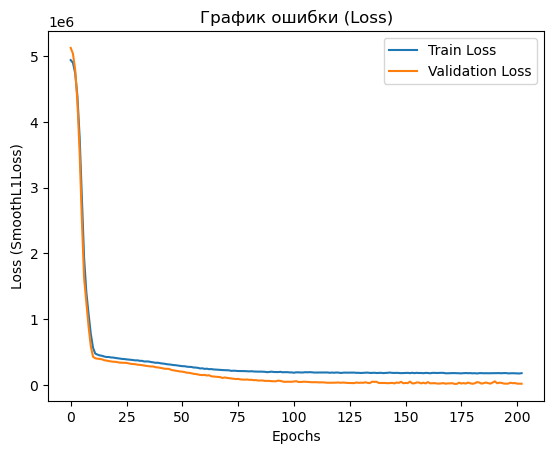

In [165]:
# График ошибки
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (SmoothL1Loss)')
plt.legend()
plt.title('График ошибки (Loss)')
plt.show()

Test Loss: 2581725952.000000
Mean Absolute Error (MAE): 43746.131227
R²: 0.999705


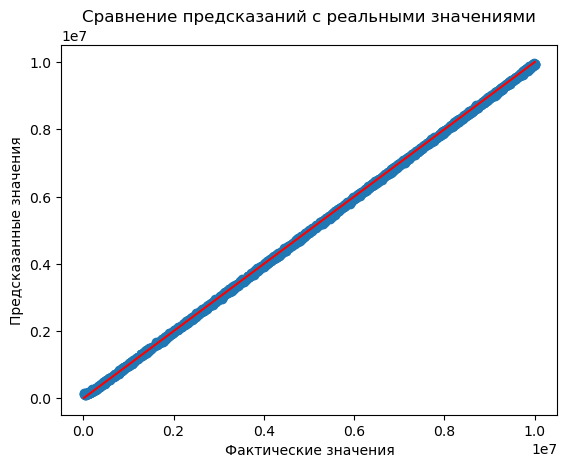

In [186]:
# Переводим модель в режим оценки
model.eval()

# Переменная для хранения общей потери
test_loss = 0.0
n_samples = 0

# Переменные для расчетов MAE и R²
y_true = torch.tensor(y_test.values)  # Преобразуем pandas.Series в torch.Tensor
y_pred = []

# Включаем отключение градиентов
with torch.no_grad():
    # Предсказания
    y_pred_tensor = model(X_test_tensor.to(device))  
    y_pred_tensor = y_pred_tensor.cpu().numpy()  # Переводим предсказания в numpy
    y_pred = y_pred_tensor

    # Вычисляем тестовую потерю
    criterion = nn.MSELoss()  # Потери для регрессии
    loss = criterion(torch.tensor(y_pred), y_test_tensor)  # Включаем реальное y
    test_loss += loss.item() * y_test_tensor.size(0)  # Умножаем на размер батча
    n_samples += y_test_tensor.size(0)

    # Средняя потеря
    avg_test_loss = test_loss / n_samples

# Вычисляем MAE и R²
mae = mean_absolute_error(y_true.numpy(), y_pred)  # Конвертируем y_true в numpy
r2 = r2_score(y_true.numpy(), y_pred)

# Выводим среднюю потерю, MAE и R²
print(f"Test Loss: {avg_test_loss:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R²: {r2:.6f}")

# Строим график
plt.scatter(y_true.numpy(), y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')

# Линия идеального предсказания
plt.plot([min(y_true.numpy()), max(y_true.numpy())], [min(y_true.numpy()), max(y_true.numpy())], color='red') 

plt.show()

## Построим модель по отфильтрованным данным и лучшим полученым параметрам

In [140]:
X_final

,quality_index,hasGuestRoom,squareMeters
0,-43094.783446,7,75523
1,-13715.766883,2,80771
2,-16250.757340,9,55712
3,-20528.176357,3,32316
4,-14068.401226,4,70429
...,...,...,...
9995,27355.568553,4,1726
9996,-15032.251094,0,44403
9997,27359.078271,9,83841
9998,4738.854559,4,59036


In [187]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [188]:
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train_final, y_train_final, test_size=0.2, random_state=42)

In [189]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val_final)
X_test_scaled = scaler.transform(X_test_final)

In [190]:
# Конвертируем в тензоры
X_train_tensor_final = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor_final = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor_final = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor_final = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor_final = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor_final = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

In [145]:
class ParisDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            # Возвращаем как тензоры
            return self.X[idx].float(), self.y[idx].float()
        return self.X[idx].float()

# Создаём датасеты
train_dataset_final = ParisDataset(X_train_tensor_final, y_train_tensor_final)
val_dataset_final = ParisDataset(X_val_tensor_final, y_val_tensor_final)  
test_dataset_final = ParisDataset(X_test_tensor_final, y_test_tensor_final)

## Создаим модель на pytorch

In [174]:
# === 1. Устанавливаем лучшие параметры ===
best_config = {
    "learning_rate": 0.001,
    "batch_size": 64,
    "dropout": 0.1044,  # округляем до 4 знаков
    "activation": "relu",
    "num_layers": 3,
    "optimizer": "Adam",
    "layers": 250
}

# === 2. Определяем устройство ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# === 3. Подготовка данных ===
train_loader_final = DataLoader(train_dataset_final, batch_size=best_config["batch_size"], shuffle=True)
test_loader_final = DataLoader(test_dataset_final, batch_size=best_config["batch_size"], shuffle=False)

# === 4. Определяем модель ===
class SimpleNN(nn.Module):
    def __init__(self, hidden_size, dropout, activation, input_dim):
        super(SimpleNN, self).__init__()
        
        # Первый слой
        self.layer1 = nn.Linear(input_dim, hidden_size)
        self.activation1 = nn.ReLU() if activation == "relu" else nn.Tanh()
        self.dropout1 = nn.Dropout(dropout)

        # Второй слой
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.activation2 = nn.ReLU() if activation == "relu" else nn.Tanh()
        self.dropout2 = nn.Dropout(dropout)

        # Третий слой
        self.layer3 = nn.Linear(hidden_size, 1)  # Выходной слой (для регрессии)
    
    def forward(self, x):
        x = self.dropout1(self.activation1(self.layer1(x)))
        x = self.dropout2(self.activation2(self.layer2(x)))
        x = self.layer3(x)
        return x

# Инициализируем модель 
model_final = SimpleNN(
    hidden_size=best_config["layers"],
    dropout=best_config["dropout"],
    activation=best_config["activation"],
    input_dim=X_final.shape[1]  
).to(device)

# === 5. Определяем функцию потерь и оптимизатор ===
criterion = nn.SmoothL1Loss()  # Huber Loss
optimizer = optim.Adam(model_final.parameters(), lr=best_config["learning_rate"])

# === 6. Создаём папку для логов TensorBoard ===
log_dir = f"tensorboard/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# === 7. Обучение модели ===
epochs = 600
best_val_loss = float("inf")
patience = 30
epochs_no_improve = 0
best_model_wts = None

for epoch in range(epochs):
    model_final.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader_final:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_final(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model_final.parameters(), clip_value=1.0)  # ограничение градиентов
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader_final)

    # === 8. Валидация ===
    model_final.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader_final:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_final(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader_final)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.6f}, Val Loss={avg_val_loss:.6f}")

    # === 9. Логируем данные в TensorBoard ===
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)

    # Логируем градиенты
    for name, param in model_final.named_parameters():
        if param.grad is not None:
            writer.add_histogram(f"Gradients/{name}", param.grad, epoch)

    # Ранняя остановка
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_wts = model_final.state_dict()  # Сохраняем лучшие веса
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

# === 10. Загружаем лучшие веса модели ===
if best_model_wts is not None:
    model_final.load_state_dict(best_model_wts)
    print("✅ Загружены лучшие веса модели.")

# === 11. Сохраняем обученную модель в папку с логами ===
model_path = os.path.join(log_dir, "final_model.pth")
torch.save(model_final.state_dict(), model_path)
print(f"📁 Модель сохранена в '{model_path}'")

# Закрываем TensorBoard writer
writer.close()

Epoch 1: Train Loss=4936442.405000, Val Loss=5128795.031250
Epoch 2: Train Loss=4935813.165000, Val Loss=5127632.703125
Epoch 3: Train Loss=4933999.722500, Val Loss=5125000.843750
Epoch 4: Train Loss=4930492.695000, Val Loss=5120390.156250
Epoch 5: Train Loss=4924810.125000, Val Loss=5113337.593750
Epoch 6: Train Loss=4916524.100000, Val Loss=5103404.375000
Epoch 7: Train Loss=4905221.960000, Val Loss=5090237.000000
Epoch 8: Train Loss=4890678.895000, Val Loss=5073799.234375
Epoch 9: Train Loss=4872964.985000, Val Loss=5054091.625000
Epoch 10: Train Loss=4851947.592500, Val Loss=5031066.421875
Epoch 11: Train Loss=4827693.800000, Val Loss=5004604.546875
Epoch 12: Train Loss=4799989.755000, Val Loss=4974495.609375
Epoch 13: Train Loss=4768344.397500, Val Loss=4940465.671875
Epoch 14: Train Loss=4733193.607500, Val Loss=4902452.671875
Epoch 15: Train Loss=4693924.367500, Val Loss=4860389.781250
Epoch 16: Train Loss=4650923.100000, Val Loss=4813905.296875
Epoch 17: Train Loss=4603544.9050

### Строим графики и получаем метрики для оценки получившейся модели

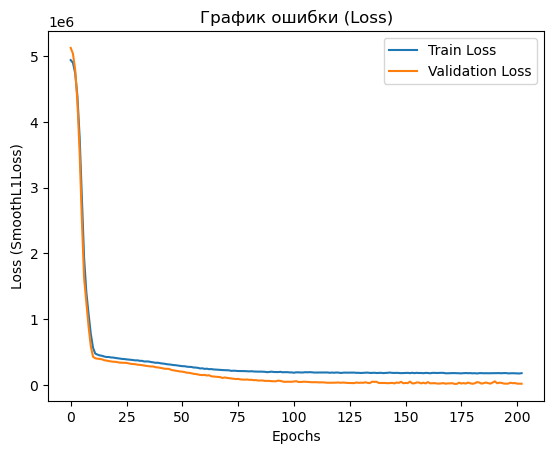

In [151]:
# График ошибки
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (SmoothL1Loss)')
plt.legend()
plt.title('График ошибки (Loss)')
plt.show()

Test Loss: 206429296.000000
Mean Absolute Error (MAE): 12298.823521
R²: 0.999976


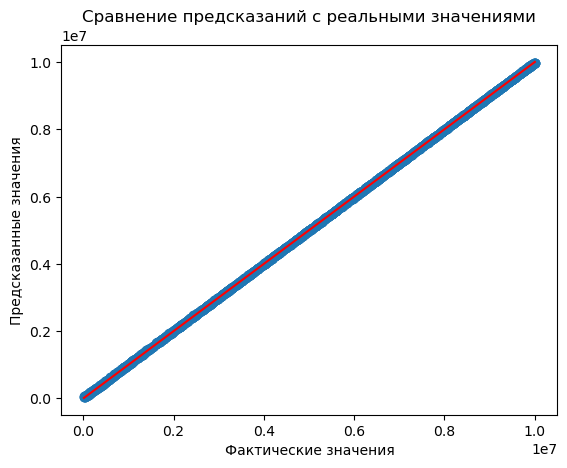

In [175]:
# Переводим модель в режим оценки
model_final.eval()

# Переменная для хранения общей потери
test_loss = 0.0
n_samples = 0

# Переменные для расчетов MAE и R²
y_true = torch.tensor(y_test_final.values)  # Преобразуем pandas.Series в torch.Tensor
y_pred = []

# Включаем отключение градиентов
with torch.no_grad():
    # Предсказания
    y_pred_tensor = model_final(X_test_tensor_final.to(device))  
    y_pred_tensor = y_pred_tensor.cpu().numpy()  # Переводим предсказания в numpy
    y_pred = y_pred_tensor

    # Вычисляем тестовую потерю
    criterion = nn.MSELoss()  # Потери для регрессии
    loss = criterion(torch.tensor(y_pred), y_test_tensor_final)  # Включаем реальное y
    test_loss += loss.item() * y_test_tensor_final.size(0)  # Умножаем на размер батча
    n_samples += y_test_tensor_final.size(0)

    # Средняя потеря
    avg_test_loss = test_loss / n_samples

# Вычисляем MAE и R²
mae = mean_absolute_error(y_true.numpy(), y_pred)  # Конвертируем y_true в numpy
r2 = r2_score(y_true.numpy(), y_pred)

# Выводим среднюю потерю, MAE и R²
print(f"Test Loss: {avg_test_loss:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R²: {r2:.6f}")

# Строим график
plt.scatter(y_true.numpy(), y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')

# Линия идеального предсказания
plt.plot([min(y_true.numpy()), max(y_true.numpy())], [min(y_true.numpy()), max(y_true.numpy())], color='red') 

plt.show()


### Вывод:
Модель с меньшим числом фич (оставлены только ключевые) работает лучше, так как:
Потеря (Loss) снизилась: 2.58 млрд → 206 млн
MAE уменьшился: 43746 → 12298
R² вырос (стал ближе к 1)
Это подтверждает, что избыточные фичи вносили шум и мешали модели!

### Попробуем протестировать нашу модель через кроссвалидацию

In [208]:
# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Класс для оборачивания нашей модели
class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model, learning_rate=0.001, epochs=100):
        self.model = model.to(device)  # Переносим модель на устройство
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def fit(self, X, y):
        # Переносим данные на устройство
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1).to(device)

        # Обучаем модель
        self.model.train()
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            y_pred = self.model(X_tensor)
            loss = self.criterion(y_pred, y_tensor)
            loss.backward()
            self.optimizer.step()
        return self

    def predict(self, X):
        # Переносим данные на устройство
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(X_tensor)
        return y_pred.cpu().numpy()  # Возвращаем результат на CPU для совместимости с numpy

In [209]:
# Теперь используем этот регрессор в cross_val_score
model_pytorch = PyTorchRegressor(model=model_final, learning_rate=0.001, epochs=100)

mse_scorer = make_scorer(mean_squared_error)

cv_scores = cross_val_score(model_pytorch, X_train_scaled, y_train_final, cv=5, scoring=mse_scorer)

print(f"Средняя MSE на кросс-валидации: {np.mean(cv_scores)}")

Средняя MSE на кросс-валидации: 106784390.18670586


In [210]:
cv_scores = cross_val_score(model_pytorch, X_train_scaled, y_train_final, cv=5, scoring='r2')

# Среднее значение R² на кросс-валидации
print(f"Средний R² на кросс-валидации: {np.mean(cv_scores)}")


Средний R² на кросс-валидации: 0.9999870136103077


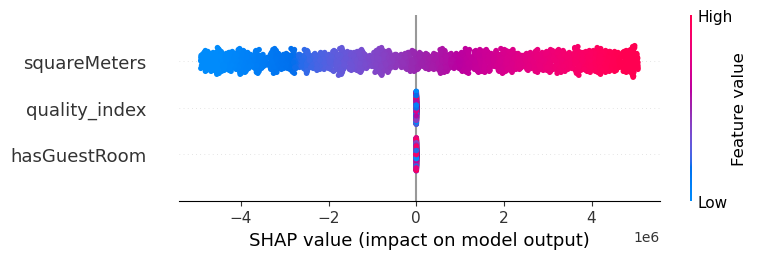

In [215]:
# Обучаем RF
feature_names = X_final.columns

# Обучаем модель RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_final)

# Используем TreeExplainer
rf_explainer = shap.TreeExplainer(rf_model)
shap_values_rf = rf_explainer.shap_values(X_test_scaled)

# Визуализация
shap.summary_plot(shap_values_rf, X_test_scaled, feature_names=feature_names)

In [216]:
# Прогнозируем на тестовых данных
y_pred_rf = rf_model.predict(X_test_scaled)

# Вычисляем MSE, MAE, и R² для случайного леса
mse_rf = mean_squared_error(y_test_final, y_pred_rf)
mae_rf = mean_absolute_error(y_test_final, y_pred_rf)
r2_rf = r2_score(y_test_final, y_pred_rf)

# Выводим результаты
print(f"Средняя MSE для Random Forest: {mse_rf}")
print(f"Средняя MAE для Random Forest: {mae_rf}")
print(f"Средний R² для Random Forest: {r2_rf}")

Средняя MSE для Random Forest: 16699149.96889502
Средняя MAE для Random Forest: 3268.9240400000567
Средний R² для Random Forest: 0.9999980934336002


### Вывод: Судя по метрикам, Random Forest (RF) работает значительно лучше по сравнению с основной моделью:
Ошибка (MSE) в RF намного ниже:
модель: 106.78 млн
RF: 16.69 млн (в 6.4 раза меньше)
MAE в RF также значительно ниже:
модель: 12 298
RF: 3 269 (в 3.7 раза меньше)
R² у RF чуть выше, но обе модели очень точны:
модель: 0.999987
RF: 0.999998 (разница минимальна)

### Вывод: 
- Первая модель (избыточные фичи)
Loss: 2.58 млрд
MAE: 43 746
R²: 0.999705

- Вторая модель (очищенные фичи,  основная)
Loss: 206 млн (в 12.5 раз меньше!)
MAE: 12 298 (в 3.5 раза меньше)
R²: 0.999976 (значительно ближе к 1)

- Random Forest
MSE (аналог Loss): 16.69 млн (ещё в 12 раз меньше)
MAE: 3 269 (в 3.7 раза лучше, чем у нашей модели)
R²: 0.999998


Вывод по всем моделям:
Уборка фичей резко улучшила модель.
Но Random Forest ещё лучше: он имеет наименьшую ошибку и лучшее обобщение.

## Попробуем еще XBoost: 

In [217]:
# Создаём модель
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=1)

# Обучаем
xgb_model.fit(X_train_scaled, y_train_final)

# Предсказания
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Метрики
mse_xgb = mean_squared_error(y_test_final, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test_final, y_pred_xgb)
r2_xgb = r2_score(y_test_final, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost R²: {r2_xgb}")

XGBoost MSE: 196259199.3346828
XGBoost MAE: 11582.848698437503
XGBoost R²: 0.9999775927998855


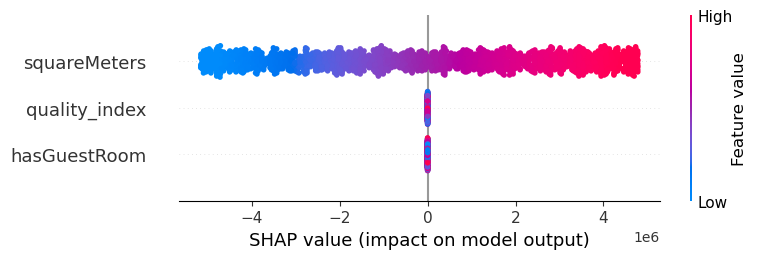

In [218]:
xgb_explainer = shap.Explainer(xgb_model, X_test_scaled)
shap_values_xgb = xgb_explainer(X_test_scaled)

shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=X_train_final.columns)

### Вывод: XGBoost оказался лучше, чем очищенная модель, и почти сравнялся с Random Forest